## Análise dos dados do dataset

In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown
from collections import Counter
from itertools import chain
from src.americanas.text.utils import token_and_remove_sw
from wordcloud import WordCloud
from nltk import word_tokenize

pd.set_option("display.max_rows", 15)
pd.set_option('display.max_columns',100)

In [7]:
df = pd.read_csv('../dataset/B2W-Reviews01.csv')

display(df.info(),df.sample())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132071 non-null  object 
 8   overall_rating         132373 non-null  int64  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            129098 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int64(1), object(12)


c:\Users\STEFA\Anaconda3\envs\apolo\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


None

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
65711,2018-03-21 16:16:17,020b965defd8250d6f6a471b7a4391320984cfa2c9b888...,25510504,Roteador Alta Potencia 1000mw Wireless 450mbps...,NaN,Informática e Acessórios,Equipamento de Rede / Wireless,Muito.bom mesmo e chegou 5 dias antes do prazo,5,Yes,Muito.bom mesmo e chegou 5 dias antes do prazo...,1983.0,M,SP


In [8]:
df.dropna(subset=['review_title', 'overall_rating','recommend_to_a_friend','review_text','reviewer_birth_year'],inplace=True)
df['reviewer_birth_year'] = df['reviewer_birth_year'].astype('int')
df['recommend_to_a_friend_cat'] = df['recommend_to_a_friend'].map({'Yes':1,'No':0})

#Dados duplicados
display(df.duplicated().sum())
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

824

## Gráficos

#### Distribuição do sexo dos usuários com relação a quantidade de avaliações

##### Neste gráfico nós vemos a distribuição do sexo dos usuários com relação a quantidade de avaliações boas ou ruins de um determinado produto. 

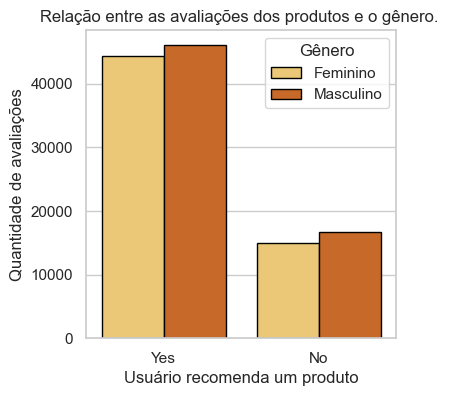

In [9]:
display(Markdown("##### Neste gráfico nós vemos a distribuição do sexo dos usuários com relação a quantidade de avaliações boas ou ruins de um determinado produto. "))
sns.set(style="whitegrid")
plt.figure(figsize=(4,4))
sns.countplot(x='recommend_to_a_friend', data = df, hue='reviewer_gender',palette='YlOrBr',edgecolor = "black")
plt.xlabel("Usuário recomenda um produto")
plt.ylabel("Quantidade de avaliações")
plt.title("Relação entre as avaliações dos produtos e o gênero. ")
plt.legend(title='Gênero', loc='upper right', labels=['Feminino', 'Masculino'])
plt.show()

#### Number of positive and negative reviews

In [10]:
def count_reviews(data):
    data1 = data[['product_name','site_category_lv1','site_category_lv2']]
    data = data['product_name'].value_counts().to_frame().reset_index()
    data.rename(columns={'index':'product_name','product_name':'Number of reviews'},inplace=True)
    data = pd.merge(
        data,
        data1[["product_name", "site_category_lv1",'site_category_lv2']],
        how="left",
        on="product_name",
    )
    data = data.drop_duplicates()
    data.rename(columns={'product_name':'Product Name',
                         'site_category_lv1':'Category 1',
                         'site_category_lv2':'Category 2'},inplace=True)
    return data

Os produtos melhor avaliados

In [63]:
pos_reviews = count_reviews(df[df['recommend_to_a_friend']=='Yes'])[0:10]
pos_reviews

,Product Name,Number of reviews,Category 1,Category 2
0,Aspirador de Pó Philco Rapid 1000N Vermelho/Pr...,704,Eletroportáteis,Aspirador e Vassoura Elétrica
704,Smartphone Motorola Moto G 5S Dual Chip Androi...,677,Celulares e Smartphones,Smartphone
1381,Smartphone Samsung Galaxy J7 Metal Dual Chip A...,590,Celulares e Smartphones,Smartphone
1971,Smartphone Motorola Moto G 5S Dual Chip Androi...,469,Celulares e Smartphones,Smartphone
2440,Smartphone Samsung Galaxy J7 Prime Dual Chip A...,429,Celulares e Smartphones,Smartphone
2869,Smartphone Samsung Galaxy J5 Prime Dual Chip A...,421,Celulares e Smartphones,Smartphone
3290,"Smart TV LED 32"" Samsung 32J4300 HD com Conver...",401,TV e Home Theater,TV
3691,Smartphone Moto G 5S Dual Chip Android 7.0 Tel...,367,Celulares e Smartphones,Smartphone
4058,Smartphone Samsung Galaxy J5 Pro Dual Chip And...,366,Celulares e Smartphones,Smartphone
4424,Smartphone Samsung Galaxy J7 Metal Dual Chip A...,359,Celulares e Smartphones,Smartphone


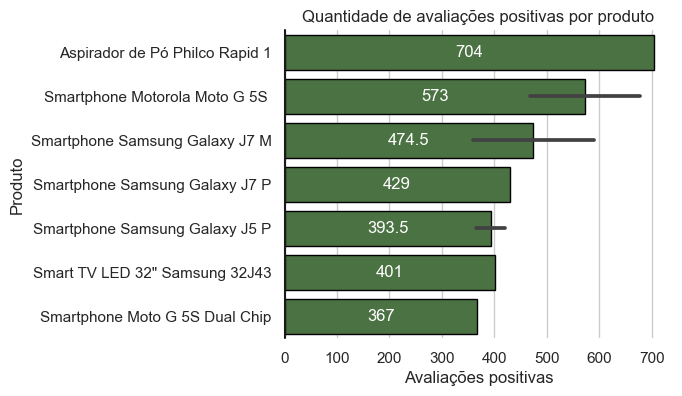

In [66]:
pos_reviews['Product Name'] = [prod[0:30] for prod in pos_reviews['Product Name']]
sns.set_style("whitegrid")
plt.figure(figsize=(5, 4))
ax = sns.barplot(data=pos_reviews, x='Number of reviews', y='Product Name', color='#467a3a',edgecolor = "black")
ax.bar_label(
    ax.containers[0],
    label_type='center',
    color='white'
)
plt.xlabel('Avaliações positivas')
plt.ylabel('Produto')
plt.title('Quantidade de avaliações positivas por produto')
ax.set(frame_on=False)
ax.axvline(0, color="k", clip_on=False)
plt.show()

Os produtos com as piores avaliações

In [73]:
neg_reviews = count_reviews(df[df['recommend_to_a_friend']=='No'])[0:10]
neg_reviews

,Product Name,Number of reviews,Category 1,Category 2
0,Game God Of War - PS4,130,Games,Playstation 4
130,"Smart TV LED 39"" Philco PH39N86DSGW HD com Con...",110,TV e Home Theater,TV
240,Smartphone Motorola Moto G 5S Dual Chip Androi...,73,Celulares e Smartphones,Smartphone
313,"Smart TV LED 32"" Samsung 32J4300 HD com Conver...",69,TV e Home Theater,TV
382,Chapinha Prancha Profissional Nano Titanium 1 ...,63,Beleza e Perfumaria,Cabelo
445,Smartphone Samsung Galaxy J7 Prime Dual Chip A...,62,Celulares e Smartphones,Smartphone
507,Smartphone Samsung Galaxy J5 Prime Dual Chip A...,61,Celulares e Smartphones,Smartphone
568,Jogo de Panelas Euro Home Ágatha Colors 5 Peça...,55,Utilidades Domésticas,Panelas
623,"Smart TV LED 55"" Philco PH55A17DSGWA4k Ultra H...",53,TV e Home Theater,TV
676,Smartphone Motorola Moto G 5S Dual Chip Androi...,53,Celulares e Smartphones,Smartphone


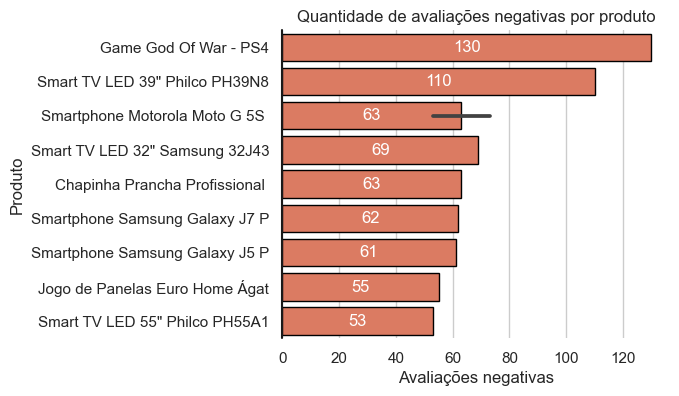

In [67]:
neg_reviews['Product Name'] = [prod[0:30] for prod in neg_reviews['Product Name']]
sns.set_style("whitegrid")
plt.figure(figsize=(5, 4))
ax = sns.barplot(data=neg_reviews, x='Number of reviews', y='Product Name', color='#ef6f4e',edgecolor = "black")
ax.bar_label(
    ax.containers[0],
    label_type='center',
    color='white'
)
plt.xlabel('Avaliações negativas')
plt.ylabel('Produto')
plt.title('Quantidade de avaliações negativas por produto')
ax.set(frame_on=False)
ax.axvline(0, color="k", clip_on=False)
plt.show()

In [84]:
def count_category(data):
    data1 = data[['site_category_lv1','site_category_lv2']]
    data = data['site_category_lv2'].value_counts().to_frame().reset_index()
    data.rename(columns={'index':'site_category_lv2','site_category_lv2':'Number of reviews'},inplace=True)
    data = pd.merge(
        data,
        data1[["site_category_lv2", "site_category_lv1"]],
        how="left",
        on="site_category_lv2",
    )
    data = data.drop_duplicates()
    data.rename(columns={'site_category_lv1':'Category 1',
                         'site_category_lv2':'Category 2'},inplace=True)
    return data

In [90]:
category = count_category(df)[0:10]
category

,Category 2,Number of reviews,Category 1
0,Smartphone,16450,Celulares e Smartphones
16450,TV,5765,TV e Home Theater
22215,Cabelo,2379,Beleza e Perfumaria
24594,Notebook,2264,Informática
26858,Acessórios para Celular,2174,Celulares e Smartphones
29032,Utensílios e Acessórios Domésticos,1976,Utilidades Domésticas
31008,Panelas,1798,Utilidades Domésticas
32806,Aspirador e Vassoura Elétrica,1669,Eletroportáteis
34475,Bebedouro e Purificador de Água,1593,Eletroportáteis
36068,Barbearia,1381,Beleza e Perfumaria


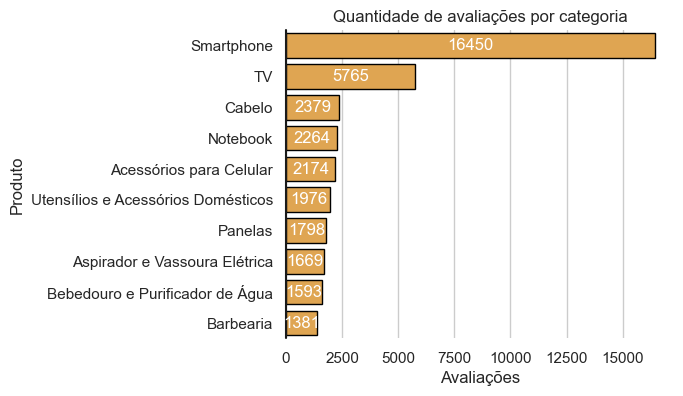

In [94]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 4))
ax = sns.barplot(data=category, x='Number of reviews', y='Category 2', color='#f6a93b',edgecolor = "black")
ax.bar_label(
    ax.containers[0],
    label_type='center',
    color='white'
)
plt.xlabel('Avaliações')
plt.ylabel('Produto')
plt.title('Quantidade de avaliações por categoria')
ax.set(frame_on=False)
ax.axvline(0, color="k", clip_on=False)
plt.show()

#### Faixa etária e avaliação

- 15-25: Grupo 1
- 25-35: Grupo 2
- 35-50: Grupo 3
- 60-100: Grupo 4

In [13]:
def age_year(age):
    if(age<100):
        age = 1900 + age
    return 2023-age

def group_age(age):
    if(age>15 and age<=25):
        return "15-30 anos"
    elif(age>25 and age<=35):
        return "30-45 anos"
    elif(age>35 and age<=50):
        return "45-60 anos"
    else:
        return "60-100 anos"

df['age'] = df['reviewer_birth_year'].apply(age_year)
#Considera como outlier todos os usuarios com idade menor do que 15 anos e acima de 100 anos 
data = df[df['age']<=100]
data = data[data['age']>15]
data['group_age'] = data['age'].apply(group_age)

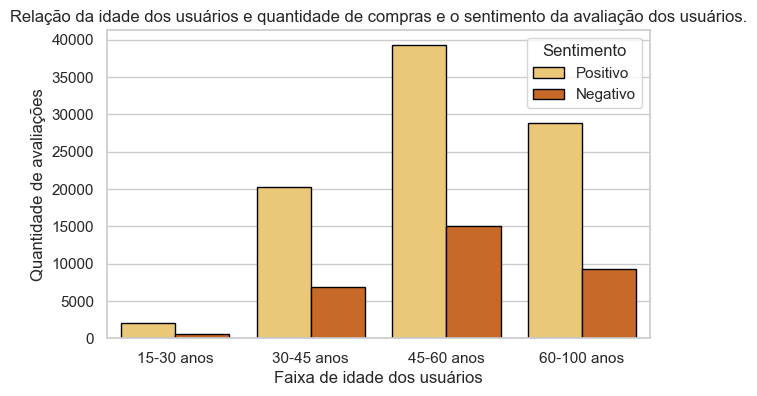

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(7,4))
sns.countplot(x='group_age', 
              data = data,
              hue='recommend_to_a_friend',
              palette='YlOrBr',
              edgecolor = "black",
              order=['15-30 anos','30-45 anos','45-60 anos','60-100 anos'])
plt.xlabel("Faixa de idade dos usuários")
plt.ylabel("Quantidade de avaliações")
plt.title("Relação da idade dos usuários e quantidade de compras e o sentimento da avaliação dos usuários.")
plt.legend(title='Sentimento', loc='upper right', labels=['Positivo', 'Negativo'])
plt.show()

#### As Palavras mais frequentes do dataset

In [105]:
data = df.copy()
data.dropna(subset=['site_category_lv2'],inplace=True)
data['text'] = data['review_title'] + ' ' + data['review_text']
data['text'] = data['text'].apply(token_and_remove_sw)
data['site_category_lv2_sw'] = data['site_category_lv2'].apply(token_and_remove_sw)

In [106]:
def count_frequency(data):
    words_counts = Counter(chain.from_iterable(list(data['text'])))
    words_freq = list(sorted(words_counts.items(), key=lambda x: x[1], reverse=True))
    data_word_frequency = pd.DataFrame(words_freq,columns = ['word', 'frequency'])
    data_word_frequency = data_word_frequency.drop(index=0)
    data_word_frequency = data_word_frequency[0:10]
    return data_word_frequency

As palavras mais citadas para boas avaliações

In [107]:
count_frequency(data[data['recommend_to_a_friend']=='Yes'])

,word,frequency
1,bom,37107
2,excelente,22522
3,recomendo,22359
4,gostei,19158
5,entrega,18855
6,ótimo,18815
7,qualidade,15011
8,bem,14310
9,prazo,12842
10,chegou,11764


As palavras mais citadas para péssimas avaliações

In [108]:
count_frequency(data[data['recommend_to_a_friend']=='No'])

,word,frequency
1,recebi,9479
2,comprei,6087
3,veio,5417
4,ainda,5262
5,entrega,4998
6,nao,4799
7,americanas,4620
8,chegou,3953
9,dia,3581
10,qualidade,3574


Nuvem de palavras para as avaliações boas e ruins.

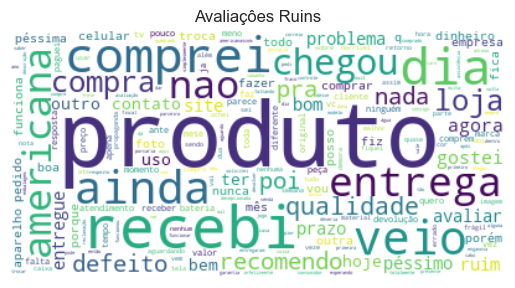

In [113]:
def wc(data,name_evaluation,col):
    all_word = ' '.join([text for text in data[col]])
    wordcloud = WordCloud(collocations=False,background_color='white').generate(all_word)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(name_evaluation)
    plt.axis("off")
    plt.show()

data['text_sw'] = data['text'].map(' '.join)
data['site_category_lv2_sw'] = data['site_category_lv2_sw'].map(' '.join)
wc(data[data['recommend_to_a_friend']=='No'],"Avaliaçôes Ruins",'text_sw')

Nuvem de palavras para avaliações boas

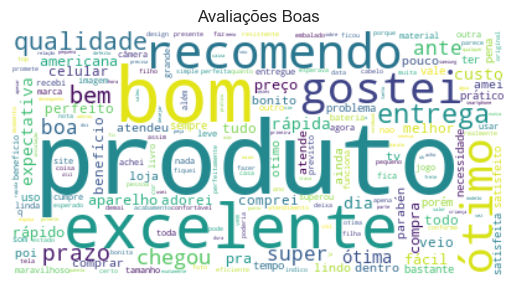

In [114]:
wc(data[data['recommend_to_a_friend']=='Yes'],"Avaliações Boas",'text_sw')

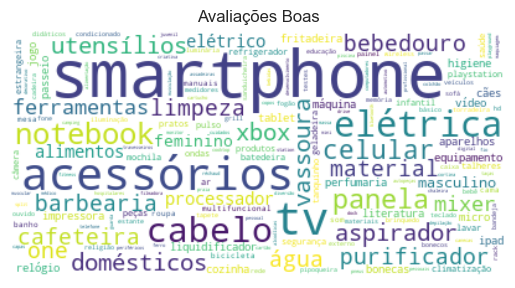

In [115]:
wc(data[data['recommend_to_a_friend']=='Yes'],"Avaliações Boas",'site_category_lv2_sw')

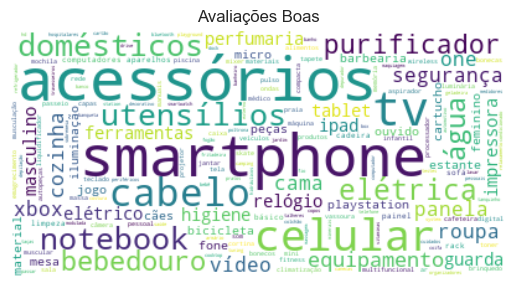

In [111]:
wc(data[data['recommend_to_a_friend']=='No'],"Avaliações Boas",'site_category_lv2_sw')

Analisando o tamanho das frases e relacionando com o  sentimento das avaliações.

In [102]:
data =  df.copy()
data['text'] = data['review_title'] + ' ' + data['review_text']
data['text'] = data['text'].apply(token_and_remove_sw)

def tam_sentencas(data):
    sentence_lengths = [len(tokens) for tokens in data['text']]
    return sentence_lengths

sentence_lengths_pos = tam_sentencas(data[data['recommend_to_a_friend']=='Yes'])
sentence_lengths_neg = tam_sentencas(data[data['recommend_to_a_friend']=='No'])

c:\Users\STEFA\Anaconda3\envs\apolo\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
c:\Users\STEFA\Anaconda3\envs\apolo\lib\site-packages\ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing impor

Text(0.5, 1.0, 'Tamanho das sentenças')

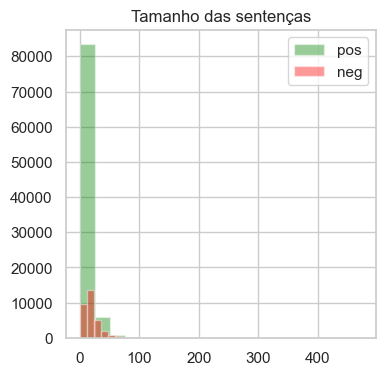

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(4,4))
ax = sns.distplot(sentence_lengths_pos, bins=18, label = 'pos', kde =False, color="green")
ax = sns.distplot(sentence_lengths_neg, bins=40, label = 'neg', kde =False, color="red")
ax.legend()
ax.set_title('Tamanho das sentenças')